In [5]:
import pandas as pd
import time

In [6]:
import math

def policy(params, substep, state_history, previous_state):
    return {'step_size': 1}

def update_a(params, substep, state_history, previous_state, policy_input):
    a = b = c = d = e = 100.0
    return 'a', previous_state['a'] * abs(math.cos(previous_state['a']))

def update_b(params, substep, state_history, previous_state, policy_input):
    return 'b', previous_state['b'] + policy_input['step_size'] * params['a']

params = {
    'a': [1, 2],
    'b': [1]
}

states = {
    'a': 1.0,
    'b': 2.0
}

psubs = [
    {
        'policies': {},
        'variables': {
            'a': update_a
        }
    },
    {
        'policies': {
            'p_1': policy,
            'p_2': policy,
            'p_3': policy,
            'p_4': policy,
            'p_5': policy,
        },
        'variables': {
            'b': update_b
        }
    }
]

---

In [7]:
TIMESTEPS = 100_000
RUNS = 1

In [11]:
import output.rad_cad as rc

start = time.time()
data_rc = rc.run(TIMESTEPS, RUNS, states, psubs, params)
end = time.time()
duration = end - start
print(duration)

4.089609861373901


In [12]:
df_radcad = pd.DataFrame(data_rc)
print(df_radcad)

               a          b  simulation  subset  run  substep  timestep
0       1.000000        2.0           0       0    1        0         0
1       0.540302        2.0           0       0    1        1         1
2       0.540302        7.0           0       0    1        2         1
3       0.463338        7.0           0       0    1        1         2
4       0.463338       12.0           0       0    1        2         2
...          ...        ...         ...     ...  ...      ...       ...
599998  0.003162  1499972.0           0       2    1        2     99998
599999  0.003162  1499972.0           0       2    1        1     99999
600000  0.003162  1499987.0           0       2    1        2     99999
600001  0.003162  1499987.0           0       2    1        1    100000
600002  0.003162  1500002.0           0       2    1        2    100000

[600003 rows x 7 columns]


In [6]:
import time
from concurrent.futures import ThreadPoolExecutor

RUNS_THREADED = 2

executor = ThreadPoolExecutor(max_workers=RUNS_THREADED)

t0 = time.time()

futures = []
results = []
for run in range(RUNS_THREADED):
    future = executor.submit(rc.run, TIMESTEPS, 1, states, psubs, params)
    futures.append(future)
    result = future.result()
    results.append(result)
t1 = time.time()

print(f"Time: {t1 - t0}s")

Time: 2.5781121253967285s


---

In [16]:
from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Experiment
from cadCAD.engine import ExecutionMode, ExecutionContext
from cadCAD.engine import Executor

In [25]:
from cadCAD import configs
del configs[:] # Clear any prior configs

config = {
    "N": RUNS,
    "T": range(TIMESTEPS),
    "M": params
}

c = config_sim(config)

exp = Experiment()
exp.append_configs(
    initial_state = states,
    partial_state_update_blocks = psubs,
    sim_configs = c
)

In [26]:
exec_mode = ExecutionMode()
local_mode_ctx = ExecutionContext(context=exec_mode.multi_mode)

In [27]:
simulation = Executor(exec_context=local_mode_ctx, configs=configs)

In [28]:
start = time.time()
data, tensor_field, sessions = simulation.execute()
end = time.time()
print(end - start)

df_cadcad = pd.DataFrame(data)
print(df_cadcad)


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: multi_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (100000, 2, 3, 7)
Execution Method: parallelize_simulations
Execution Mode: parallelized
Total execution time: 17.63s
17.644710063934326


,a,b,simulation,subset,run,substep,timestep
0,1.000000,2.0,0,0,1,0,0
1,0.540302,2.0,0,0,1,1,1
2,0.540302,7.0,0,0,1,2,1
3,0.463338,7.0,0,0,1,1,2
4,0.463338,12.0,0,0,1,2,2
...,...,...,...,...,...,...,...
599998,0.003162,1499972.0,0,2,2,2,99998
599999,0.003162,1499972.0,0,2,2,1,99999
600000,0.003162,1499987.0,0,2,2,2,99999
600001,0.003162,1499987.0,0,2,2,1,100000


In [31]:
from pandas.testing import assert_frame_equal

assert_frame_equal(df_radcad.drop(['run'], axis=1), df_cadcad.drop(['run'], axis=1))

---

In [13]:
time_profile = []

for i in range(7):
    timesteps = 10**i
    start = time.time()
    data_rc = rc.run(timesteps, 1, states, psubs, params)
    end = time.time()
    duration = end - start
    time_profile.append({'timesteps': timesteps, 'duration': duration})

<AxesSubplot:xlabel='timesteps'>

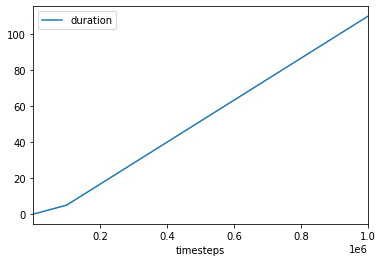

In [14]:
pd.DataFrame(time_profile).plot(x='timesteps', y='duration')

---

In [21]:
%%capture
time_profile_cadcad = []

for i in range(7):
    timesteps = 10**i
    
    from cadCAD import configs
    del configs[:] # Clear any prior configs

    config = {
        "N": 1,
        "T": range(timesteps),
        "M": params
    }

    c = config_sim(config)

    exp = Experiment()
    exp.append_configs(
        initial_state = states,
        partial_state_update_blocks = psubs,
        sim_configs = c
    )
    
    exec_mode = ExecutionMode()
    local_mode_ctx = ExecutionContext(context=exec_mode.local_mode)
    
    simulation = Executor(exec_context=local_mode_ctx, configs=configs)
    
    start = time.time()

    data, tensor_field, sessions = simulation.execute()

    end = time.time()
    duration = end - start
    time_profile_cadcad.append({'timesteps': timesteps, 'duration': duration})

<AxesSubplot:xlabel='timesteps'>

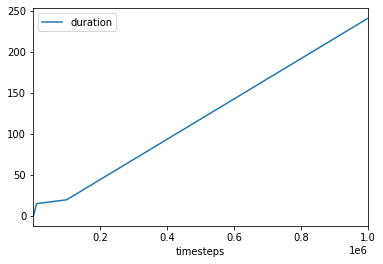

In [22]:
pd.DataFrame(time_profile_cadcad).plot(x='timesteps', y='duration')

---

<AxesSubplot:xlabel='timesteps'>

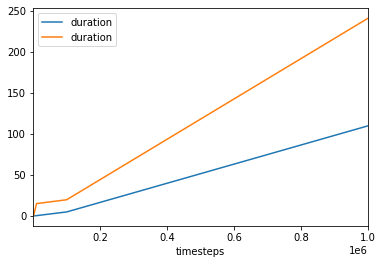

In [23]:
df_rc = pd.DataFrame(time_profile)
df_cc = pd.DataFrame(time_profile_cadcad)

ax = df_rc.plot(x='timesteps', y='duration')
df_cc.plot(ax=ax, x='timesteps', y='duration')

In [24]:
time_profile_cadcad[6]['duration']/time_profile[6]['duration']

2.1943631267523993

---

In [77]:
result = [states]

def run():
    for i in range(TIMESTEPS):
        previous_state = result[-1]
        next_state = {}
        for psub in psubs:
            for state in psub['updates']:
                next_state.update({
                    state: psub['updates'][state](previous_state)
                })
        result.append(next_state)
    return result

start = time.time()
data = run()
end = time.time()
print(end - start)

df = pd.DataFrame(data)
df

0.17743897438049316


,a,b
0,1.000000,2.0
1,0.540302,3.0
2,0.463338,4.0
3,0.414486,5.0
4,0.379389,6.0
...,...,...
99996,0.003162,99998.0
99997,0.003162,99999.0
99998,0.003162,100000.0
99999,0.003162,100001.0
